In [1]:

import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.

cos_client = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='MiFgTFmUBVFs8IUP9xxYYk5jnS2JPNL9LcccRS6tMe95',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/identity/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.direct.us-south.cloud-object-storage.appdomain.cloud')

bucket = 'telelawanalysis-donotdelete-pr-bmpbgzjj30qzi9'
object_key = 'Tele-Law Case Registrations.csv'

body = cos_client.get_object(Bucket=bucket,Key=object_key)['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_2 = pd.read_csv(body)
df_2.head(10)


,Category,States/UT's,Districts,No. of CSCs,Female,Male,Total,General,OBC,SC,ST,Total.1
0,Case Registered,Andaman and Nicobar,Nicobar,5,615,852,1467,557,315,546,49,1467
1,Case Registered,Andaman and Nicobar,North and Middle Andaman,37,765,1114,1879,199,187,1436,57,1879
2,Case Registered,Andaman and Nicobar,South Andaman,31,340,251,591,42,89,430,30,591
3,Case Registered,Andhra Pradesh,Alluri Sitharama Raju,430,6370,6828,13198,3585,4660,3176,1777,13198
4,Case Registered,Andhra Pradesh,Anakapalli,646,6311,6267,12578,3532,4196,4347,503,12578
5,Case Registered,Andhra Pradesh,Anantapur,577,10050,21628,31678,9189,8651,12245,1593,31678
6,Case Registered,Andhra Pradesh,Annamayya,501,2039,1181,3220,1173,776,1118,153,3220
7,Case Registered,Andhra Pradesh,Bapatla,461,1756,1960,3716,1729,680,1120,187,3716
8,Case Registered,Andhra Pradesh,Chittoor,724,24254,12256,36510,19944,8818,7115,633,36510
9,Case Registered,Andhra Pradesh,East Godavari,300,5908,7332,13240,7032,3230,2370,608,13240


--- VERIFYING CLEANED COLUMN NAMES ---
Index(['Category', 'State_UT', 'Districts', 'CSCs', 'Female', 'Male',
       'General', 'OBC', 'SC', 'ST', 'Total_Cases'],
      dtype='object')


--- GENDER ANALYSIS ---
Total Male Cases: 24862532
Total Female Cases: 15956220


/opt/conda/envs/Python-RT24.1/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


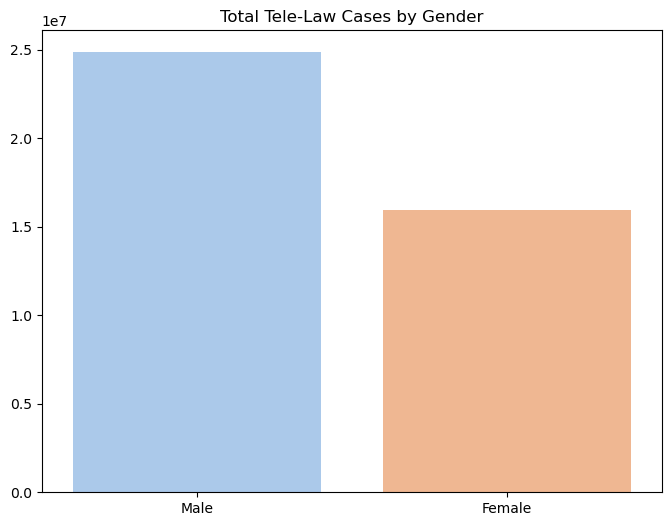



--- CASTE ANALYSIS ---
     Caste  Total Cases
1      OBC     12931124
2       SC     12921364
0  General      9479618
3       ST      5486646


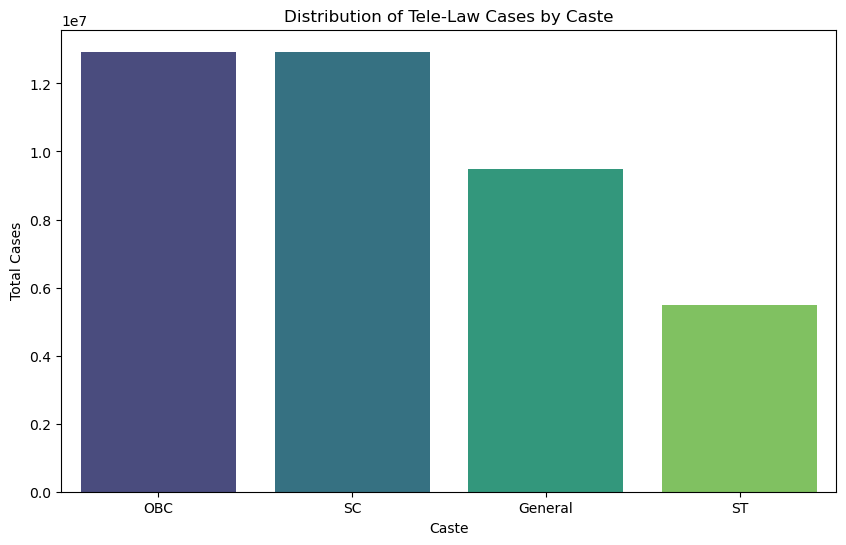



--- GEOGRAPHIC ANALYSIS (FIXED) ---
State_UT
Total (36 States/UT's)    20409376
Uttar Pradesh              3688417
Madhya Pradesh             2164028
Maharashtra                1593236
Jammu and Kashmir          1302643
Rajasthan                  1294118
Bihar                      1100029
Chhattisgarh                996342
Jharkhand                   926786
Gujarat                     862579
Name: Total_Cases, dtype: int64


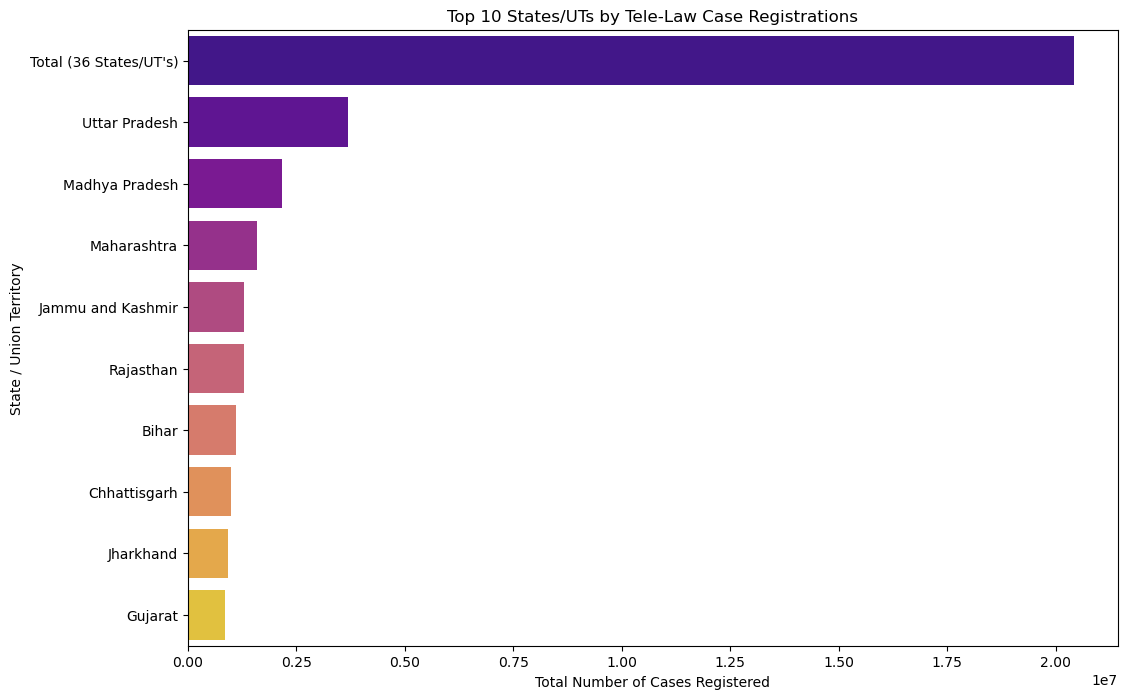

In [ ]:

df_clean = df_2.copy()


# ===================================================================
# STEP 2: CLEAN THE DATA
# ===================================================================
# Using a dictionary to map the original messy names to clean names
rename_dict = {
    "States/UT's": 'State_UT',
    'No. of CSCs': 'CSCs',
    'Total.1': 'Total_Cases'
}

# Perform the rename
df_clean.rename(columns=rename_dict, inplace=True)

# Drop the original 'Total' column which is ambiguous
if 'Total' in df_clean.columns:
    df_clean.drop(columns=['Total'], inplace=True)

print("--- VERIFYING CLEANED COLUMN NAMES ---")
print(df_clean.columns)
print("\n" + "="*50 + "\n")


# ===================================================================
# STEP 3: RERUN ALL ANALYSIS
# ===================================================================
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- Gender Analysis ---
print("--- GENDER ANALYSIS ---")
total_male = df_clean['Male'].sum()
total_female = df_clean['Female'].sum()
print(f"Total Male Cases: {total_male}")
print(f"Total Female Cases: {total_female}")

plt.figure(figsize=(8, 6))
sns.barplot(x=['Male', 'Female'], y=[total_male, total_female], palette='pastel')
plt.title('Total Tele-Law Cases by Gender')
plt.show()
print("\n" + "="*50 + "\n")


# --- Caste Analysis ---
print("--- CASTE ANALYSIS ---")
caste_totals = {
    'General': df_clean['General'].sum(),
    'OBC': df_clean['OBC'].sum(),
    'SC': df_clean['SC'].sum(),
    'ST': df_clean['ST'].sum()
}
caste_df = pd.DataFrame(list(caste_totals.items()), columns=['Caste', 'Total Cases']).sort_values('Total Cases', ascending=False)
print(caste_df)

plt.figure(figsize=(10, 6))
sns.barplot(x='Caste', y='Total Cases', data=caste_df, palette='viridis')
plt.title('Distribution of Tele-Law Cases by Caste')
plt.show()
print("\n" + "="*50 + "\n")


# --- Geographic Analysis ---
print("--- GEOGRAPHIC ANALYSIS (FIXED) ---")
state_wise_cases = df_clean.groupby('State_UT')['Total_Cases'].sum().sort_values(ascending=False)
top_10_states = state_wise_cases.head(10)
print(top_10_states)

plt.figure(figsize=(12, 8))
sns.barplot(x=top_10_states.values, y=top_10_states.index, palette='plasma', orient='h')
plt.title('Top 10 States/UTs by Tele-Law Case Registrations')
plt.xlabel('Total Number of Cases Registered')
plt.ylabel('State / Union Territory')
plt.show()